# Reglerentwurf

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from IPython.display import display, Image, Latex
from scipy.integrate import solve_ivp

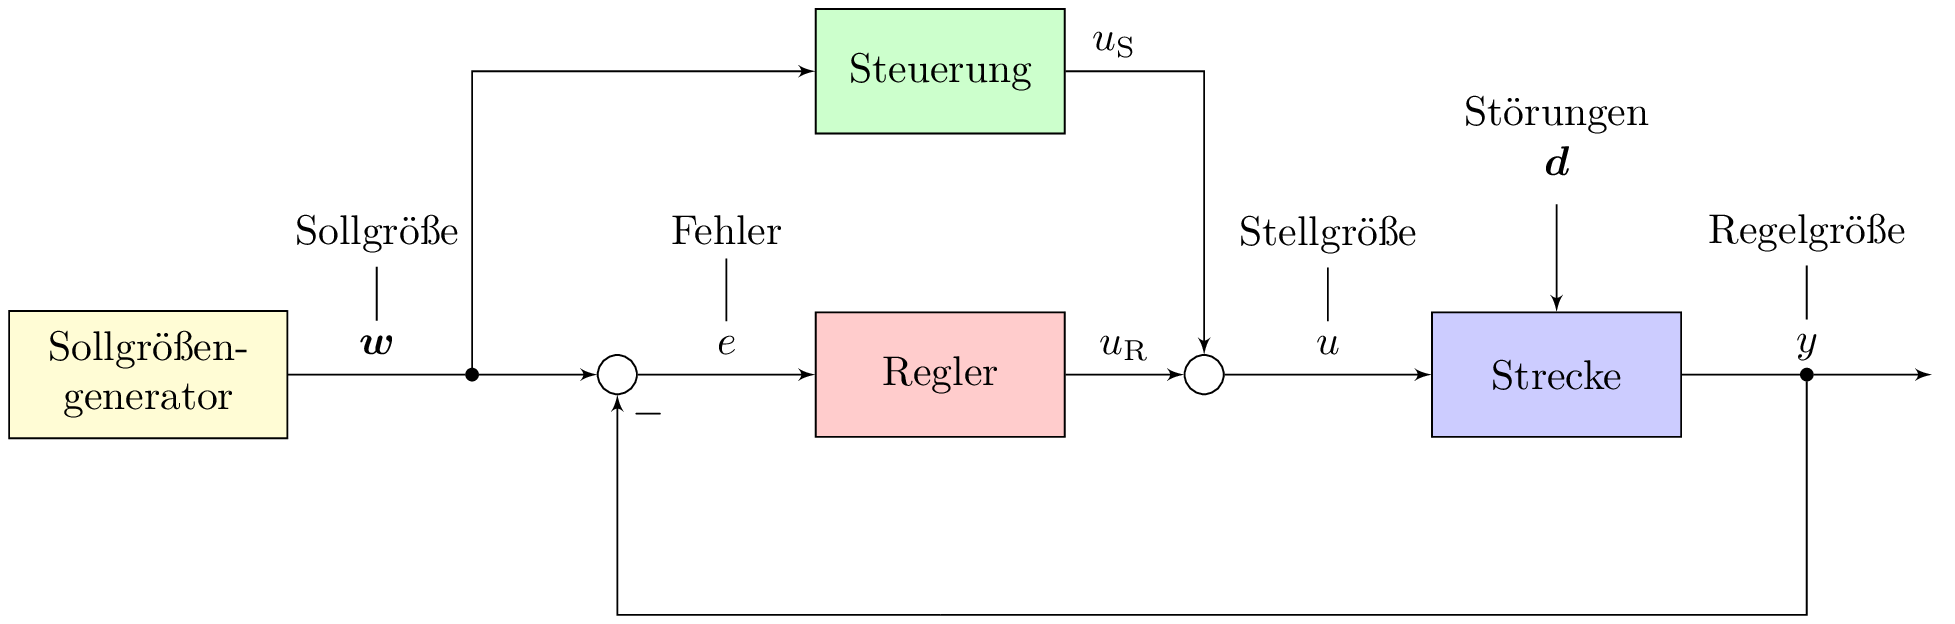

In [2]:
imag = Image("../images/feedback.png", width=600)
display(imag)

Ziel ist der Entwurf eines Reglers auf Basis des linearisierten Modells des Zweitanksystems
\begin{align*}
    T_1 T_2 \ddot{\tilde{z}}_2(t) + (T_1 + T_2)\dot{\tilde{z}}_2(t) + \tilde{z}_2(t) & = \tilde{u}_{\mathrm{A}}(t)
\end{align*}

### 1. Eintragen der notwendigen Systemparameter

In [ ]:
buA = 9
# Physikalisch
KPhy = 0.147763421835044
T1Phy = 34.567259359529
T2Phy = 68.2115206317666
bz2Phy = 0.137092448385557
# Messung
KMessung = 0.05335540886113588
T1Messung = 11.796537856412515
T2Messung = 80.74097989401139
bz2Messung = 0.13238994944989588

### 2. Bestimmung der Reglerparameter mittels Symmetrischen Optimums

In [ ]:
# with modelled parameters
Kp_sym_analytic = T1_analytic / (2*Kp_analytic*T2_analytic)
Ki_sym_analytic = Kp_sym_analytic / T1_analytic

# with parameters of pt2 measurement
Kp_sym_pt2 = T1_pt2 / (2*Kp_pt2*T2_pt2)
Ki_sym_pt2 = Kp_sym_pt2 / T1_pt2

# with parameters of pt1 measurements
Kp_sym_pt1 = T1_pt1 / (2*Kp_pt1*T2_pt1)
Ki_sym_pt1 = Kp_sym_pt1 / T1_pt1

# print results
dp = 5 # decimal places
d = {   'KP': [round(Kp_sym_analytic,dp), round(Kp_sym_pt2,dp), round(Kp_sym_pt1,dp)],
        'KI': [round(Ki_sym_analytic,dp), round(Ki_sym_pt2,dp), round(Ki_sym_pt1,dp)],}
print ("{:<5} {:<11} {:<9} {:<11}".format(' ','modelling','PT2','PT1'))
for name, values in d.items():
    s1, s2, s3 = values
    print ("{:<5} {:<11} {:<9} {:<11}".format(name, s1, s2, s3))

### 3. Vergleich der Steuerung an den Modellen

__Simulation__

Definition nichtlineares Modell

In [3]:
def nonLinSys(t, z, uA):
    z1 = z[0]
    z2 = z[1]
        
    hV1 = 0.055
    hV2 = 0.055
    
    dz = np.zeros(2)
    dz[0] = 0.00216625315586689 * (uA(t) - 6.4) - 0.0127646468529449 * np.sqrt(2) * np.sqrt(hV1 + z1)
    dz[1] = 0.0127646468529449 * np.sqrt(2) * np.sqrt(hV1 + z1) - 0.00908683019582126 * np.sqrt(2) * np.sqrt(hV2 + z2)

    return dz

Definition linearisiertes Modell

In [ ]:
def linSys(t, x, uA, T1Sys, T2Sys, KSys, buA):
    A = np.array([[0, 1],
                  [-1 / (T1Sys * T2Sys), -(T1Sys + T2Sys) / (T1Sys * T2Sys)]])
    B = np.array([[0],
                  [KSys / (T1Sys * T2Sys)]])
    return A.dot(x) + B.dot(np.array([uA(t) - buA]))

In [ ]:
timeDom = np.linspace(0, 200, 2000)
z0 = [0, 0]

resPhyLin = solve_ivp(linSys, [timeDom[0], timeDom[-1]], z0 - np.array([bz2Phy, 0]), t_eval=timeDom, args=(uAr, T1Phy, T2Phy, KPhy, buA))
resPhyNichtLin = solve_ivp(nonLinSys, [timeDom[0], timeDom[-1]], z0, t_eval=timeDom, args=(uAr, ))
resMessung = solve_ivp(linSys, [timeDom[0], timeDom[-1]], z0 - np.array([bz2Messung, 0]), t_eval=timeDom, args=(uAr, T1Messung, T2Messung, KMessung, buA))

NameError: name 'timeDom' is not defined

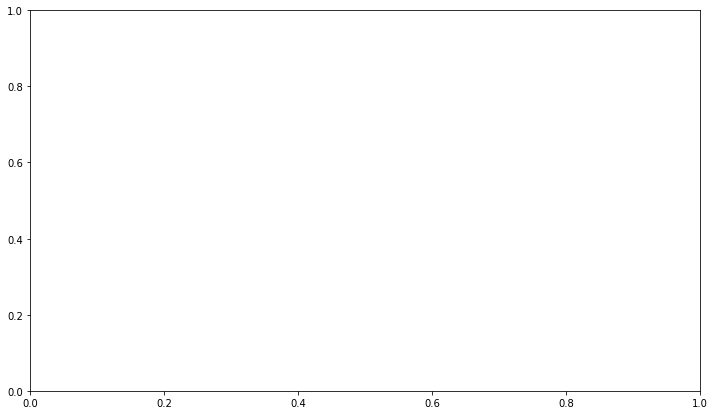

In [4]:
plt.close()

fig1, axes10 = plt.subplots(1, 1, figsize=(12,7))

axes10.plot(timeDom, resPhyNichtLin.y[1], label='physikalisch nichtlinear')
axes10.plot(timeDom, resPhyLin.y[0] + bz2Phy, label='physikalisch linearisiert')
axes10.plot(timeDom, resMessung.y[0] + bz2Messung, label=r'identifiziert')

axes11 = axes10.twinx() 

axes11.plot(timeDom, [uAr(t) for t in timeDom], color='C4')
axes11.tick_params(axis='y', labelcolor='C4')

axes10.set_ylabel(r'$z_2$ / $m$]')
axes11.set_ylabel(r'$u_{\mathrm{A}}$ / $V$', color='C4')
axes10.set_xlabel(r'Zeit / $s$')

handlesAx1, labelsAx1 = axes10.get_legend_handles_labels()
axes10.legend([handle for i, handle in enumerate(handlesAx1)],
              [label for i, label in enumerate(labelsAx1)],
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=9, mode="expand", borderaxespad=0., framealpha=0.5)

axes10.grid()
plt.show()